In [1]:
import os
import numpy as np
import pandas as pd
import fastparquet
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc


from joblib import Parallel, delayed
from scipy.stats import kurtosis
import category_encoders as ce


from sklearn.model_selection import GroupKFold, cross_val_score 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
import optuna
import lightgbm as lgb

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = r'C:\Users\asus\Desktop\Stock-Volatility-Prediction-\optiver-realized-volatility-prediction'

In [3]:
book_train_raw = pd.read_parquet(f'{DATA_DIR}/book_train.parquet/stock_id=0')

In [4]:
trade_train_raw = pd.read_parquet(f"{DATA_DIR}/trade_train.parquet/stock_id=0")

Text(0, 0.5, 'Price')

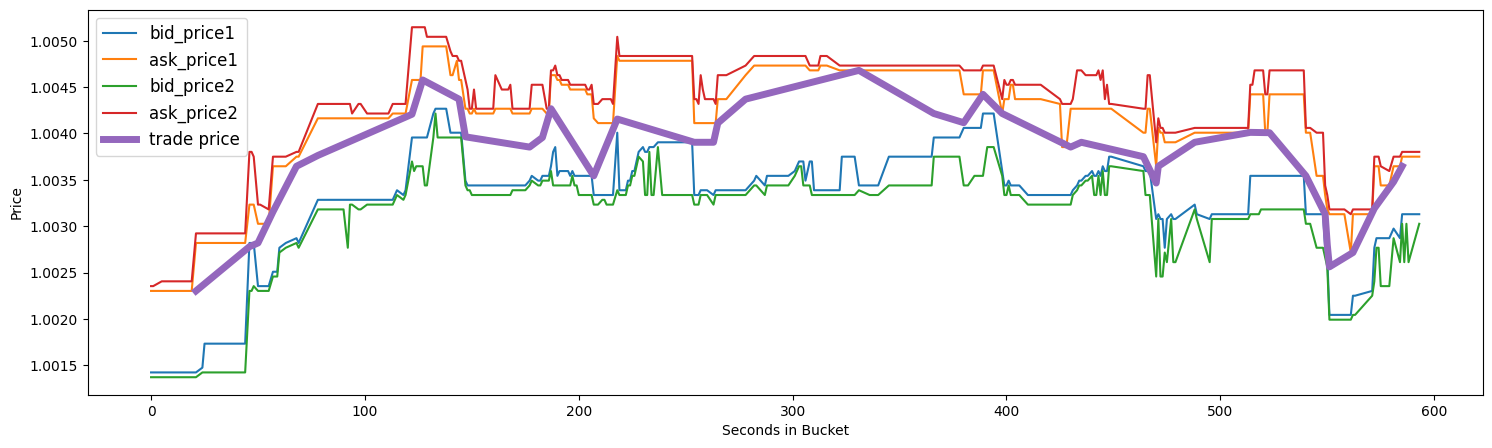

In [5]:
book_to_plot = book_train_raw.loc[book_train_raw.time_id==5]
trade_to_plot = trade_train_raw.loc[trade_train_raw.time_id==5]

samples = ['bid_price1', 'ask_price1','bid_price2', 'ask_price2']
plt.figure(figsize=(18,5))
for feature in samples: 
    plt.plot(book_to_plot["seconds_in_bucket"], book_to_plot[feature], label=feature)
plt.plot(trade_to_plot["seconds_in_bucket"],trade_to_plot["price"], label="trade price", lw=5)
plt.legend(fontsize=12)
plt.xlabel("Seconds in Bucket")
plt.ylabel("Price")

In [6]:
df_train_raw = pd.read_csv(f'{DATA_DIR}/train.csv')
df_test_raw = pd.read_csv(f'{DATA_DIR}/test.csv')
sample_submission = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [7]:
def calc_log_ret(prices):
    x = np.log(prices)
    return np.diff(x, prepend=[x[0]])

In [8]:
def book_preprocess(file_path):
    
    df = pd.read_parquet(file_path)
    
    # Weighted Average Prices (WAP1 & WAP2)
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    
    # Log Returns for WAP1 and WAP2
    df['log_ret1'] = df.groupby('time_id')['wap1'].transform(lambda x: calc_log_ret(x.to_numpy()))
    df['log_ret2'] = df.groupby('time_id')['wap2'].transform(lambda x: calc_log_ret(x.to_numpy()))
    
    # WAP Balance
    df['wap_balance'] = df['wap1'] - df['wap2']
    
    # Price Spread, Bid Spread, Ask Spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    
    # Total Volume and Volume Imbalance
    df['total_volume'] = df['ask_size1'] + df['ask_size2'] + df['bid_size1'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Mid Price Change
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['mid_price_change'] = df.groupby('time_id')['mid_price'].transform(lambda x: x.diff())
    
    
    df['avg_bid_ask_spread'] = (df['ask_price1'] - df['bid_price1']) / (df['ask_price1'] + df['bid_price1'])
    df['bid_ask_spread_volatility'] = df.groupby('time_id')['avg_bid_ask_spread'].transform('std')

    # Rolling Volatility for WAP1 and WAP2
    df['rolling_volatility_wap1'] = df.groupby('time_id')['log_ret1'].transform(lambda x: x.rolling(window=30).std())
    df['rolling_volatility_wap2'] = df.groupby('time_id')['log_ret2'].transform(lambda x: x.rolling(window=30).std())
    
    # Liquidity Measures - Depth Ratio
    df['depth_ratio'] = (df['bid_size1'] + df['bid_size2']) / (df['ask_size1'] + df['ask_size2'])
    
    # Skewness and Kurtosis
    df['log_ret1_skew'] = df.groupby('time_id')['log_ret1'].transform('skew')
    df['log_ret2_skew'] = df.groupby('time_id')['log_ret2'].transform('skew')
    
    df['price_spread_skew'] = df.groupby('time_id')['price_spread'].transform('skew')
    df['volume_imbalance_skew'] = df.groupby('time_id')['volume_imbalance'].transform('skew')
    
    df['log_ret1_kurtosis'] = df.groupby('time_id')['log_ret1'].transform(lambda x: kurtosis(x, fisher=False))
    df['log_ret2_kurtosis'] = df.groupby('time_id')['log_ret2'].transform(lambda x: kurtosis(x, fisher=False))  # Unbiased kurtosis
    
    df['order_flow_imbalance'] = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
    df['liquidity_gap'] = (df['ask_price2'] - df['bid_price2']) - (df['ask_price1'] - df['bid_price1'])
    
    # Temporal Encoding
    df['time_sin'] = np.sin(2 * np.pi * df['seconds_in_bucket'] / 86400)
    df['time_cos'] = np.cos(2 * np.pi * df['seconds_in_bucket'] / 86400)
    
    # VWAP Calculation
    df['vwap'] = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    
    # Create the Feature Aggregation Dictionary
    create_feature_dict = {
        'wap1': ['mean', 'std'],
        'wap2': ['mean', 'std'], 
        'log_ret1': ['std'],
        'log_ret2': ['std'],
        'wap_balance': ['mean', 'std'],
        'price_spread': ['mean', 'std'],
        'bid_spread': ['mean', 'std'],
        'ask_spread': ['mean', 'std'],
        'volume_imbalance': ['mean', 'std'],
        'total_volume': ['mean', 'std'],
        'depth_ratio':['mean', 'std'],
        'vwap':['mean', "std"],
        'rolling_volatility_wap2':["mean", "std"],
        'rolling_volatility_wap1':["mean", "std"],
        'log_ret1_skew':["mean"],
        'log_ret2_skew':['mean'],
        'volume_imbalance_skew':['mean'],
        'price_spread_skew':['mean'],
        'log_ret1_kurtosis':['mean'],
        'log_ret2_kurtosis':['mean'],
        'order_flow_imbalance': ['mean', 'std', 'skew'],
        'liquidity_gap': ['mean', 'std'],
        'time_sin': ['mean'],
        'time_cos': ['mean']
        }
    
       # Feature Aggregation
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    # Flatten Columns
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    # Additional Features for Last 300s, 120s
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(df[df['seconds_in_bucket'] >= 600 - second]).groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(df_feature, df_feature_sec, how='left', left_on='time_id',right_on=f'time_id_{second}')
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    # Add Row ID
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
    
    return df_feature


In [9]:
book_preprocess(f'{DATA_DIR}/book_train.parquet/stock_id=0')

,wap1_mean,wap1_std,wap2_mean,wap2_std,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,...,log_ret1_kurtosis_mean_120,log_ret2_kurtosis_mean_120,order_flow_imbalance_mean_120,order_flow_imbalance_std_120,order_flow_imbalance_skew_120,liquidity_gap_mean_120,liquidity_gap_std_120,time_sin_mean_120,time_cos_mean_120,row_id
0,1.003725,0.000693,1.003661,0.000781,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,...,5.404960,7.469052,-32.018182,162.396918,0.257643,0.000411,0.000255,0.039371,0.999223,0-5
1,1.000239,0.000262,1.000206,0.000272,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,...,14.439831,6.892627,56.282609,126.661871,0.598366,0.000420,0.000228,0.039002,0.999237,0-11
2,0.999542,0.000864,0.999680,0.000862,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,...,9.278814,6.646224,-154.321429,133.874472,0.114031,0.000448,0.000312,0.038375,0.999259,0-16
3,0.998832,0.000757,0.998633,0.000656,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,...,13.814140,8.661703,-72.461538,200.532880,-0.118928,0.000174,0.000050,0.039450,0.999219,0-31
4,0.999619,0.000258,0.999626,0.000317,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,...,16.768414,5.519189,100.750000,121.383062,-0.279864,0.000317,0.000064,0.038669,0.999249,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.997938,0.000747,0.997864,0.000769,0.000150,0.000222,0.000074,0.000255,0.000552,0.000202,...,9.807566,5.909123,-112.918367,229.624316,-0.390467,0.000274,0.000096,0.038939,0.999239,0-32751
3826,1.000310,0.000551,1.000487,0.000599,0.000154,0.000199,-0.000177,0.000278,0.000542,0.000147,...,14.379394,9.868262,-200.428571,194.823040,0.066571,0.000259,0.000125,0.039694,0.999209,0-32753
3827,0.999552,0.000743,0.999456,0.000736,0.000213,0.000239,0.000096,0.000288,0.000525,0.000244,...,6.270886,4.948925,-77.431373,135.609034,0.080862,0.000242,0.000090,0.039160,0.999230,0-32758
3828,1.002357,0.000356,1.002386,0.000424,0.000174,0.000292,-0.000029,0.000307,0.000480,0.000145,...,6.587950,5.917373,-81.682540,136.221691,0.158198,0.000266,0.000198,0.039184,0.999229,0-32763


In [10]:
def trade_preprocess(file_path):
    df = pd.read_parquet(file_path)
    df['log_ret'] = df.groupby('time_id')['price'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    aggregate_dictionary = {
        'log_ret': ['std'],
        'size': ['sum', 'mean', 'std'],
        'order_count': ['sum', 'mean', 'std'],
    }
    df_feature = df.groupby('time_id').agg(aggregate_dictionary).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(df[df['seconds_in_bucket'] >= 600 - second]).groupby(['time_id']).agg(aggregate_dictionary).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(df_feature, df_feature_sec,how='left', left_on='time_id',right_on=f'time_id_{second}')
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
      
    return df_feature

In [11]:
trade_preprocess(f'{DATA_DIR}/trade_train.parquet/stock_id=0')

,log_ret_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,log_ret_std_300,size_sum_300,size_mean_300,...,order_count_mean_300,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,row_id
0,0.000319,3179,79.475000,118.375107,110,2.750000,2.467741,0.000290,1587.0,75.571429,...,2.571429,2.292846,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,0-5
1,0.000165,1289,42.966667,77.815203,57,1.900000,1.446756,0.000151,900.0,56.250000,...,2.250000,1.807392,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,0-11
2,0.000387,2161,86.440000,113.587000,68,2.720000,2.300725,0.000275,1189.0,99.083333,...,3.166667,2.691175,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,0-16
3,0.000387,1962,130.800000,144.828569,59,3.933333,4.043808,0.000381,1556.0,172.888889,...,5.111111,4.702245,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,0-31
4,0.000190,1791,81.409091,117.914682,89,4.045455,4.099678,0.000143,1219.0,110.818182,...,4.909091,4.887833,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.000211,3450,66.346154,118.944852,159,3.057692,3.018982,0.000193,2365.0,67.571429,...,3.257143,3.248012,0.000192,904.0,64.571429,85.998850,37.0,2.642857,2.205139,0-32751
3826,0.000270,4547,162.392857,218.445406,109,3.892857,4.314826,0.000320,2161.0,180.083333,...,4.250000,4.114829,0.000246,201.0,100.500000,140.714249,4.0,2.000000,1.414214,0-32753
3827,0.000254,4250,118.055556,141.328583,126,3.500000,3.660601,0.000267,2294.0,104.272727,...,3.727273,4.165411,0.000221,295.0,49.166667,56.654803,13.0,2.166667,1.602082,0-32758
3828,0.000249,3217,60.698113,81.077737,114,2.150943,1.935461,0.000287,1627.0,65.080000,...,1.920000,1.552417,0.000306,1235.0,123.500000,95.394211,28.0,2.800000,2.097618,0-32763


In [12]:
def preprocessor(stock_id_list, train_mode = True):
    
    from joblib import Parallel, delayed # parallel computing
    
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if train_mode:
            file_path_book = f'{DATA_DIR}/book_train.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_train.parquet/stock_id={stock_id}'
        else:
            file_path_book = f'{DATA_DIR}/book_test.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_test.parquet/stock_id={stock_id}'
            
        df_temp = pd.merge(book_preprocess(file_path_book), trade_preprocess(file_path_trade), on='row_id', how='left')
        
        df_temp['time_id'] = df_temp['row_id'].str.split('-').str[1].astype(int)
        
        return pd.concat([df,df_temp])
    
    df = Parallel(n_jobs=-1, verbose=1)(delayed(for_joblib)(stock_id) for stock_id in stock_id_list)

    df =  pd.concat(df, ignore_index = True)
    
    return df

In [14]:
train_stock_id_list = df_train_raw['stock_id'].unique()
df_train = preprocessor(train_stock_id_list, train_mode = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  7.8min finished


In [15]:
df_train_temp = df_train_raw.copy()
df_train_temp['row_id'] = df_train_raw['stock_id'].astype(str) + '-' + df_train_raw['time_id'].astype(str)
df_train_temp = df_train_temp[['row_id', 'target']]
df_train = pd.merge(df_train, df_train_temp, on = ['row_id'], how = 'right') #merging on row id.
df_train['stock_id'] = df_train['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
df_train.drop(['row_id'],axis=1,inplace=True)

In [16]:
df_train

,wap1_mean,wap1_std,wap2_mean,wap2_std,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,...,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,time_id,target,stock_id
0,1.003725,0.000693,1.003661,0.000781,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,...,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,5,0.004136,0
1,1.000239,0.000262,1.000206,0.000272,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,...,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,11,0.001445,0
2,0.999542,0.000864,0.999680,0.000862,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,...,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,16,0.002168,0
3,0.998832,0.000757,0.998633,0.000656,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,...,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,31,0.002195,0
4,0.999619,0.000258,0.999626,0.000317,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,...,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,62,0.001747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.999582,0.000486,0.999585,0.000613,0.000210,0.000334,-0.000003,0.000453,0.000878,0.000235,...,0.000357,159.0,17.666667,32.260657,15.0,1.666667,1.000000,32751,0.003461,126
428928,1.002476,0.001264,1.002602,0.001303,0.000275,0.000334,-0.000126,0.000352,0.000706,0.000228,...,0.000339,321.0,32.100000,61.156357,19.0,1.900000,0.994429,32753,0.003113,126
428929,1.001082,0.000466,1.000996,0.000599,0.000195,0.000377,0.000086,0.000492,0.000739,0.000240,...,0.000608,130.0,43.333333,65.683585,8.0,2.666667,2.886751,32758,0.004070,126
428930,1.001809,0.000456,1.001790,0.000507,0.000184,0.000269,0.000019,0.000290,0.000530,0.000172,...,0.000175,1284.0,91.714286,95.347485,38.0,2.714286,2.554892,32763,0.003357,126


In [17]:
test_stock_id_list = df_test_raw['stock_id'].unique()
df_test = preprocessor(test_stock_id_list, train_mode = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [18]:
df_test_temp = df_test_raw.copy()
df_test_temp['row_id'] = df_test_raw['stock_id'].astype(str) + '-' + df_test_raw['time_id'].astype(str)
df_test_temp = df_test_temp[['row_id']]
df_test = pd.merge(df_test, df_test_temp, on = ['row_id'], how = 'right')
df_test['stock_id'] = df_test['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
df_test.drop(['row_id'],axis=1,inplace=True)

In [19]:
df_test

,wap1_mean,wap1_std,wap2_mean,wap2_std,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,...,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,time_id,stock_id
0,1.000405,0.00017,1.00055,0.000153,0.00017,0.000138,-0.000145,0.000022,0.000557,0.000028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [20]:
#1. Prepare Training/Test Data (Add this after your preprocessing)
# --------------------------
# Split df_train into features and target
X_train = df_train.drop(columns=['target'])
Y_train = df_train['target']

# Test data (no target column)
X_test = df_test.copy()

In [21]:
# 2. Handle Missing Values Properly (Add this section)
# --------------------------
# Fill NaNs using training data statistics to prevent leakage
# Convert categorical columns to numeric if necessary
X_train_numeric = X_train.select_dtypes(include=[np.number])  # Select only numeric columns
train_medians = X_train_numeric.median()

# First check where the NaN values are
print("Columns with NaN in X_train:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

print("\nColumns with NaN in X_test:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

# Simple but effective fix
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)  # Use X_train median for X_test to prevent data leakage

# Verify fix
print("\nAfter fix - NaN in X_train:", X_train.isnull().sum().sum())
print("After fix - NaN in X_test:", X_test.isnull().sum().sum())

Columns with NaN in X_train:
rolling_volatility_wap2_mean           1
rolling_volatility_wap2_std            1
rolling_volatility_wap1_mean           1
rolling_volatility_wap1_std            1
rolling_volatility_wap2_mean_300       1
                                    ... 
size_mean_120                       3067
size_std_120                        9608
order_count_sum_120                 3067
order_count_mean_120                3067
order_count_std_120                 9608
Length: 68, dtype: int64

Columns with NaN in X_test:
wap1_mean               2
wap1_std                2
wap2_mean               2
wap2_std                2
log_ret1_std            2
                       ..
size_std_120            3
order_count_sum_120     3
order_count_mean_120    3
order_count_std_120     3
time_id                 2
Length: 139, dtype: int64

After fix - NaN in X_train: 0
After fix - NaN in X_test: 0


In [22]:
#Target Encoding
t_encoder = ce.TargetEncoder()

# Fit on training data only
t_encoder.fit(X_train['stock_id'], Y_train)

# Transform both datasets
X_train['stock_id'] = t_encoder.transform(X_train['stock_id'])
X_test['stock_id'] = t_encoder.transform(X_test['stock_id'])

In [23]:
#Final Data Preparation
# Keep only numeric features
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
X_train = X_train[numeric_cols]
X_test = X_test[numeric_cols]

In [24]:
# Evaluation Metrics
def rmspe(y_true, y_pred):
    """Root Mean Square Percentage Error"""
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def rmspe_lgb(y_pred, y_true):
    """Custom RMSPE for LightGBM"""
    y_true = y_true.get_label()
    return 'RMSPE', np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))), False

In [25]:
# 2. Hyperparameter Optimization with Optuna
# --------------------------
def optimize_hyperparameters(X_train, Y_train):
    def objective(trial):
        params = {
           'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': trial.suggest_categorical('n_estimators', [2500]),
            'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.03),
            'num_leaves': trial.suggest_int('num_leaves', 100, 150),
            'max_depth': trial.suggest_int('max_depth', 9, 11),
            'reg_alpha': trial.suggest_float('reg_alpha', 9.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8)
        }
        
        model = LGBMRegressor(**params)
        score = cross_val_score(
            model, X_train, Y_train, 
            cv=GroupKFold(n_splits=5), 
            groups=X_train['stock_id'],
            scoring=make_scorer(rmspe, greater_is_better=False),
            n_jobs=-1
        ).mean()
        return score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)
    return study.best_params

In [26]:
# 3. Enhanced Model Training
def train_and_predict(X_train, X_val, y_train, y_val, X_test):
    # Get optimized params
    best_params = optimize_hyperparameters(X_train, y_train)
    
    # ===== ENHANCED MODEL ARCHITECTURE =====
    final_model = StackingRegressor(
        estimators=[
            ('lgb', LGBMRegressor(**best_params)),
            ('mlp', MLPRegressor(
                hidden_layer_sizes=(256, 128),
                early_stopping=True,
                random_state=42
            ))
        ],
        final_estimator=Ridge(alpha=0.5),
        cv=5
    )
    
    # Train the model (without passing 'groups' to StackingRegressor)
    final_model.fit(
        X_train.drop(columns=['stock_id']), 
        y_train
    )
    
    # Predict on validation set
    val_preds = final_model.predict(X_val.drop(columns=['stock_id']))
    
    # Predict on test set
    test_preds = final_model.predict(X_test.drop(columns=['stock_id']))
    test_preds = np.clip(test_preds, Y_train.min(), Y_train.max())
    
    return final_model, val_preds, test_preds


In [27]:
# 4. Temporal Validation (Replace your train_val_split)
def temporal_validation(X, y):
    cv = GroupKFold(n_splits=5)
    group_ids = X['time_id']  # Critical for time-based leakage prevention
    
    # Initialize lists to store predictions and scores
    all_val_preds = []
    all_val_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=group_ids)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model and get predictions
        model, val_preds, _ = train_and_predict(X_train, X_val, y_train, y_val, X_test)
        
        # Store validation predictions
        all_val_preds.append(val_preds)
        
        # Calculate fold score
        fold_score = rmspe(y_val, val_preds)
        all_val_scores.append(fold_score)
        print(f'Fold {fold+1} RMSPE: {fold_score:.4f}')
    
    # Combine all validation predictions for final evaluation
    combined_val_preds = np.concatenate(all_val_preds)
    overall_rmspe = rmspe(y, combined_val_preds)
    print(f'Overall RMSPE: {overall_rmspe:.4f}')


In [28]:
def main():
    # Prepare data
    features = [col for col in df_train.columns if col not in ['target']]
    X = X_train[features].copy()  # to avoid settingwithcopywarning
    y = df_train['target'].copy()  # Get target from df_train instead of X_train
    
    # Temporal Validation
    temporal_validation(X, y)
    
    # Final Training
    final_model, _, test_preds = train_and_predict(
       X_train, None, Y_train, None, X_test
    )
    
    # Generate Submission
    submission = pd.DataFrame({
        'row_id': sample_submission['row_id'],
        'target': test_preds
    })
    submission.to_csv('optimized_submission.csv', index=False)
    print("Optimized submission saved!")

# Run the model0
main()

[I 2025-02-06 01:55:46,344] A new study created in memory with name: no-name-6e126506-5b81-4d34-9283-f6a486c97a95
C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C

MemoryError: Unable to allocate 56.1 MiB for an array with shape (109, 67408) and data type float64